In [77]:
import numpy as np
import gc
import copy
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

import os
import pickle
import matplotlib
import seaborn as sns

from feat_loading import *

In [20]:
gc.collect()
app_train = load_dataframe("train_all2.csv")
app_test = load_dataframe("test_all2.csv")
app_train, app_test = load_extra_feats_post(app_train, app_test)
to_del = del_useless_cols(app_train)
app_test = app_test.drop(to_del, axis=1)


0 columns need to be dropped


In [21]:
for alg in ["RF", "ET", "CB", "XG"
#             "MLP"
           ]:
    oof = load_dataframe(alg + "_oof.csv")
    app_train = app_train.merge(right=oof.reset_index(), how='left', on='SK_ID_CURR')
    if "index" in app_train.columns:
        app_train = app_train.drop("index", axis=1)
    del oof
    gc.collect()
    
    t_oof = load_dataframe(alg + "_test.csv")
    app_test = app_test.merge(right=t_oof.reset_index(), how='left', on='SK_ID_CURR')
    if "index" in app_test.columns:
        app_test = app_test.drop("index", axis=1)
    del t_oof
    gc.collect()

In [22]:
test = load_dataframe("improved_lgb_all_tables_more.csv")
test.columns = ['SK_ID_CURR', "LGB"]

lgboof = load_dataframe("LGB_oof.csv")

app_train = app_train.merge(right=lgboof.reset_index(), how='left', on='SK_ID_CURR')
if "index" in app_train.columns:
    app_train = app_train.drop("index", axis=1)
del lgboof
gc.collect()

app_test = app_test.merge(right=test.reset_index(), how='left', on='SK_ID_CURR')
if "index" in app_test.columns:
    app_test = app_test.drop("index", axis=1)
del test
gc.collect()


28

In [11]:
# app_train = app_train.drop("index_x", axis=1)
# app_test = app_test.drop("index_x", axis=1)
# app_train = app_train.drop("index_y", axis=1)
# app_test = app_test.drop("index_y", axis=1)

In [24]:
with open("good_feats.bin", "rb") as f:
    good_feats = pickle.load(f)
    
ready_train = app_train[good_feats + ['SK_ID_CURR', "TARGET", "RF", "ET", "CB", "LGB", "XG"]]
ready_test = app_test[good_feats + ['SK_ID_CURR', "RF", "ET", "CB", "LGB", "XG"]]

In [25]:
app_train.head()

,SK_ID_CURR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,...,birth_div_reg,ANN_LENGTH_EMPLOYED_RATIO,age_finish,ANN_LENGTH_AGE_RATIO,NEW_DOC_IND_KURT,RF,ET,CB,MLP,LGB
0,100002,202500.0,406597.5,24700.5,0.018801,-9461,-637.0,-3648.0,-2120,NaN,...,2.593476,-0.025842,27.292307,3.972353e-07,20.0,0.133470,0.111521,0.551934,1.338416e-03,0.204268
1,100003,270000.0,1293502.5,35698.5,0.003541,-16765,-1188.0,-1186.0,-291,NaN,...,14.135750,-0.030500,48.951014,4.934460e-07,20.0,0.035103,0.041009,0.075232,8.947332e-99,0.012681
2,100004,67500.0,135000.0,6750.0,0.010032,-19046,-225.0,-4260.0,-2531,26.0,...,4.470892,-0.088889,53.847489,2.397464e-07,0.0,0.059222,0.063006,0.144619,1.733422e-01,0.041665
3,100006,135000.0,312682.5,29686.5,0.008019,-19005,-3039.0,-9833.0,-2437,NaN,...,1.932777,-0.003466,52.946228,1.265326e-07,20.0,0.067127,0.100749,0.102485,7.958846e-02,0.030604
4,100007,121500.0,513000.0,21865.5,0.028663,-19932,-3038.0,-4311.0,-3458,NaN,...,4.623521,-0.007723,56.563354,2.687404e-07,20.0,0.064339,0.075361,0.297315,4.917194e-48,0.071715


In [12]:
"LGB" in app_train.columns

True

In [25]:
import modelling
importlib.reload(modelling)

gc.collect()
new_params = dict(
        boosting_type="goss", n_estimators=10000, objective='binary',
        learning_rate=0.005, n_jobs=5, random_state=50,
        subsample=0.81, reg_alpha=0.4, reg_lambda=0.4, min_child_samples=30,
        max_depth=8, colsample_bytree=0.8, num_leaves=45
    )
cat_feats = [
    'NAME_CONTRACT_TYPE', 
              'FLAG_OWN_CAR', 
             'FLAG_OWN_REALTY']
submission, fi, metrics = modelling.model(ready_train, ready_test, 
#                                           cat_feats, 
                                          parallel=5, lgbm_params=new_params)
print('Baseline metrics')
print(metrics)
submission.to_csv('stacked.csv', index = False)

Training until validation scores don't improve for 200 rounds.
[200]	train's binary_logloss: 0.238521	train's auc: 0.804405	valid's binary_logloss: 0.239664	valid's auc: 0.795375
Early stopping, best iteration is:
[58]	train's binary_logloss: 0.258314	train's auc: 0.800847	valid's binary_logloss: 0.257078	valid's auc: 0.795521
Training until validation scores don't improve for 200 rounds.
[200]	train's binary_logloss: 0.238148	train's auc: 0.804995	valid's binary_logloss: 0.241298	valid's auc: 0.793821
Early stopping, best iteration is:
[81]	train's binary_logloss: 0.252663	train's auc: 0.801619	valid's binary_logloss: 0.254068	valid's auc: 0.794044
Training until validation scores don't improve for 200 rounds.
[200]	train's binary_logloss: 0.238287	train's auc: 0.803779	valid's binary_logloss: 0.240852	valid's auc: 0.797684
[400]	train's binary_logloss: 0.229874	train's auc: 0.812217	valid's binary_logloss: 0.234975	valid's auc: 0.797623
Early stopping, best iteration is:
[257]	train'

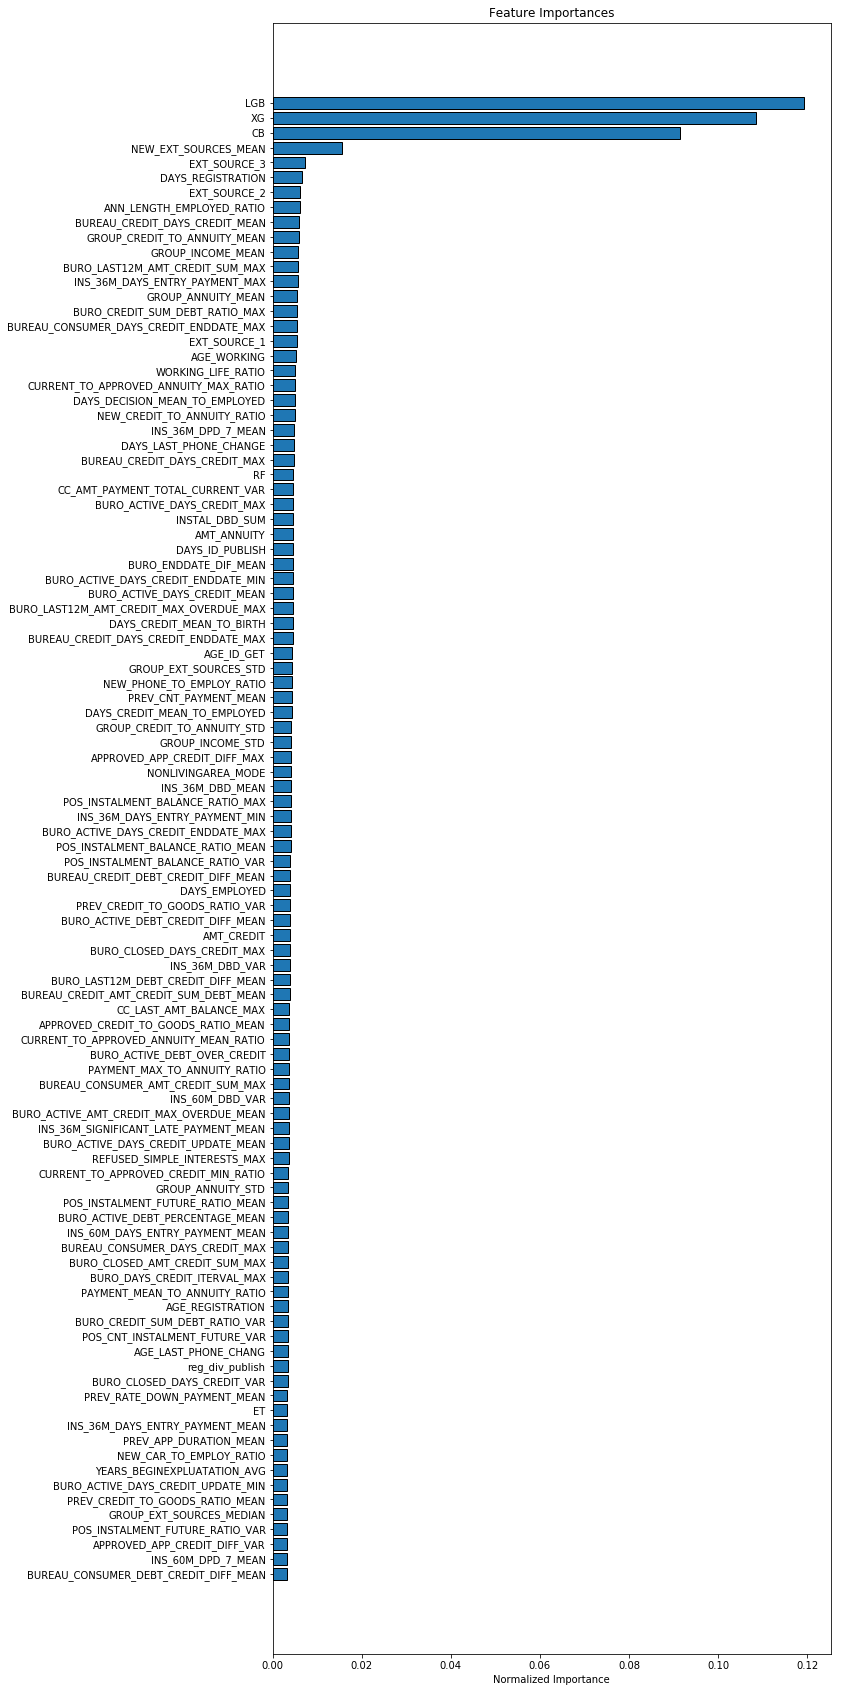

['CC_LIMIT_USE_MEAN', 'BURO_CREDIT_CURRENCY_currency 4_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Business development_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Car repairs_MEAN', 'BURO_CREDIT_TYPE_Cash loan (non-earmarked)_MEAN', 'BURO_CREDIT_CURRENCY_currency 3_MEAN', 'CC_NAME_CONTRACT_STATUS_Demand_MEAN', 'INS_12M_AMT_BALANCE_MEAN', 'FLAG_DOCUMENT_2', 'FLAG_EMP_PHONE', 'PREV_CHANNEL_TYPE_Car dealer_MEAN', 'FLAG_OWN_CAR', 'CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN', 'NAME_INCOME_TYPE_Student', 'BURO_CREDIT_TYPE_Loan for the purchase of equipment_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Gasification / water supply_MEAN', 'FLAG_DOCUMENT_10', 'PREV_NAME_GOODS_CATEGORY_Insurance_MEAN', 'POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN', 'REG_CITY_NOT_WORK_CITY', 'PREV_NAME_CONTRACT_TYPE_XNA_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Buying a garage_MEAN', 'NAME_EDUCATION_TYPE_Secondary / secondary special', 'PREV_NAME_GOODS_CATEGORY_Weapon_MEAN', 'NAME_INCOME_TYPE_Pensioner', 'ORGANIZATION_TYPE_XNA', 'CC_CNT_DRAWIN

In [26]:
importlib.reload(modelling)
fi_sorted = modelling.plot_feature_importances(fi, 100)
# display(fi_sorted[fi_sorted["feature"]=="ORG_XNA_no_Pensioner"])
print(fi_sorted[fi_sorted["importance"]==0]["feature"].tolist())

In [24]:
oof_path = "oof"

test = load_dataframe(os.path.join(oof_path, "improved_lgb_all_tables21.csv"))
test.columns = ['SK_ID_CURR', "LGB"]

oof = load_dataframe(os.path.join(oof_path, "LGB_oof.csv"))


In [ ]:
app_test = load_dataframe("test_all.csv")
app_train = load_dataframe("train_all.csv")

In [25]:
for file in os.listdir(oof_path):
    if not file.endswith(".csv"):
        continue
    df = load_dataframe(os.path.join(oof_path, file))
    if file.endswith("oof.csv") and "LGB" not in file:
        oof = oof.merge(right=df.reset_index(), how='left', on='SK_ID_CURR')
        oof = oof.drop("index", axis=1)
    elif file.endswith("test.csv"):
        test = test.merge(right=df.reset_index(), how='left', on='SK_ID_CURR')
        test = test.drop("index", axis=1)

In [36]:
X = oof.drop(['SK_ID_CURR', "ET"], axis=1)
y = app_train["TARGET"]
tX = test.drop(['SK_ID_CURR', "ET",
                "TARGET"
               ], axis=1)
lr = LogisticRegressionCV()
lr.fit(X, y)
test['TARGET'] = lr.predict_proba(tX)[:,1]
test[['SK_ID_CURR', 'TARGET']].to_csv('stacking_submission4.csv', index=False, float_format='%.8f')

In [34]:
X = oof.drop(['SK_ID_CURR'], axis=1)
y = app_train["TARGET"]
tX = test.drop(['SK_ID_CURR', 
                "TARGET"
               ], axis=1)
tc = DecisionTreeClassifier()
tc.fit(X, y)
test['TARGET'] = tc.predict_proba(tX)[:,1]
test[['SK_ID_CURR', 'TARGET']].to_csv('stacking_submission3.csv', index=False, float_format='%.8f')

In [ ]:
from skopt import BayesSearchCV

bayes_tuner = BayesSearchCV(
    LogisticRegressionCV(scoring="auc", random_state=200),
    dict(
        Cs=(1e-5, 100), 
        fit_intercept=[True, False], 
        cv='warn', 
        tol=(1e-7, 1e+3, 'log-uniform'), 
        max_iter=(70, 1000), 
        refit=[True, False], 
        multi_class='warn',
    )
    n_iter = 500
)

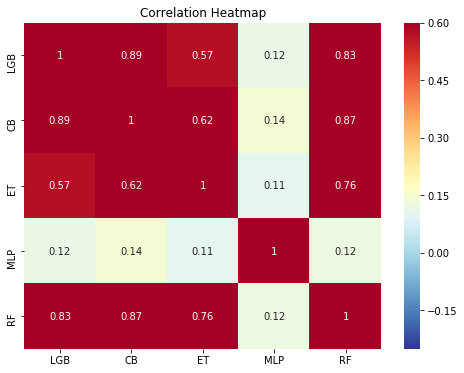

In [49]:
data_corrs = oof.drop(['SK_ID_CURR'], axis=1).corr()
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

try blending

In [124]:
rf = load_dataframe("rf_submission.csv")
cb = load_dataframe("cb_submission.csv")
et = load_dataframe("et_submission.csv")
xg = load_dataframe("xg_submission.csv")
lgb = load_dataframe("improved_lgb_all_tables_more.csv")

res = rf.loc[:, ['SK_ID_CURR']]
res['TARGET'] = lgb['TARGET'] * 0.45 + xg['TARGET'] * 0.45 + cb['TARGET'] * 0.03 + et['TARGET'] * 0.02 + rf['TARGET'] * 0.05
res[['SK_ID_CURR', 'TARGET']].to_csv('blending4.csv', index=False, float_format='%.8f')

In [72]:
blend_train = app_train[['SK_ID_CURR', "TARGET", "RF", "ET", "CB", "LGB", "XG"]]
blend_test = app_test[['SK_ID_CURR', "RF", "ET", "CB", "LGB", "XG"]]

from sklearn.model_selection import KFold


n_folds=5
clf_proto = LogisticRegressionCV(cv=5, Cs=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], scoring='roc_auc')

train_ids = blend_train['SK_ID_CURR']
test_ids = blend_test['SK_ID_CURR']
blend_test = blend_test.drop(['SK_ID_CURR'], axis=1)
y = blend_train["TARGET"]
X = blend_train.drop(["TARGET", 'SK_ID_CURR'], axis=1)

k_fold = KFold(n_splits=n_folds, shuffle=True, random_state=250)
res = np.zeros((5,))

for i, (train_indices, predict_indices) in enumerate(k_fold.split(X)):
    print("%s/%s fold processing" % (i+1, n_folds))

    tnX, tny = X.loc[train_indices, :], y[train_indices]
    pX = X.loc[predict_indices, :]
    clf = copy.deepcopy(clf_proto)
    clf.fit(tnX, tny)
    print(clf.score(pX, y[predict_indices]))
    print(clf.C_)
#     train_oof[predict_indices] = clf.predict_proba(pX)[:, 1]
    res += clf.coef_[0]

    gc.enable()
    del tnX, tny, clf, pX
    gc.collect()
    print("%s/%s fold finished" % (i+1, n_folds))

del X, y, train_ids, test_ids
gc.collect()
res/res.sum()

1/5 fold processing


c:\program files\python36\lib\site-packages\sklearn\linear_model\logistic.py:1917: ChangedBehaviorWarning: The long-standing behavior to use the accuracy score has changed. The scoring parameter is now used. This warning will disappear in version 0.22.
  ChangedBehaviorWarning)


0.7924094440486449
[0.001]
1/5 fold finished
2/5 fold processing


c:\program files\python36\lib\site-packages\sklearn\linear_model\logistic.py:1917: ChangedBehaviorWarning: The long-standing behavior to use the accuracy score has changed. The scoring parameter is now used. This warning will disappear in version 0.22.
  ChangedBehaviorWarning)


0.7934790617773881
[0.001]
2/5 fold finished
3/5 fold processing


c:\program files\python36\lib\site-packages\sklearn\linear_model\logistic.py:1917: ChangedBehaviorWarning: The long-standing behavior to use the accuracy score has changed. The scoring parameter is now used. This warning will disappear in version 0.22.
  ChangedBehaviorWarning)


0.7947048325660524
[0.001]
3/5 fold finished
4/5 fold processing


c:\program files\python36\lib\site-packages\sklearn\linear_model\logistic.py:1917: ChangedBehaviorWarning: The long-standing behavior to use the accuracy score has changed. The scoring parameter is now used. This warning will disappear in version 0.22.
  ChangedBehaviorWarning)


0.7953391750789708
[0.001]
4/5 fold finished
5/5 fold processing
0.789959352934745
[0.001]
5/5 fold finished


c:\program files\python36\lib\site-packages\sklearn\linear_model\logistic.py:1917: ChangedBehaviorWarning: The long-standing behavior to use the accuracy score has changed. The scoring parameter is now used. This warning will disappear in version 0.22.
  ChangedBehaviorWarning)


array([0.09624315, 0.04713997, 0.40201843, 0.23294556, 0.22165289])

In [84]:
blend_train = app_train[['SK_ID_CURR', "TARGET", "RF", "ET", "CB", "LGB", "XG"]]
blend_test = app_test[['SK_ID_CURR', "RF", "ET", "CB", "LGB", "XG"]]

from sklearn.model_selection import KFold

Cs=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
n_folds=5
y = blend_train.loc[1000:, ["TARGET"]]
X = blend_train.drop(["TARGET", 'SK_ID_CURR'], axis=1).loc[1000:, :]
ty = blend_train.loc[:1000, ["TARGET"]]
tX = blend_train.drop(["TARGET", 'SK_ID_CURR'], axis=1).loc[:1000, :]

for c in Cs:
    clf = LogisticRegression(C=c, n_jobs=-1)
    clf.fit(X, y)
    print(roc_auc_score(ty, clf.predict_proba(tX)[:, 1]))
    print(c)
    print(clf.coef_[0])



c:\program files\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\program files\python36\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\program files\python36\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


0.8475218658892129
0.0001
[-0.03838341 -0.09464731  0.06412183  0.11416471  0.11218127]


c:\program files\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\program files\python36\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\program files\python36\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


0.8408009820469542
0.001
[0.29087899 0.02379298 1.56250559 1.03597242 0.98415519]


c:\program files\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\program files\python36\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\program files\python36\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


0.8403406475372104
0.01
[0.59218963 0.24280056 2.90387304 1.68762245 1.3072904 ]


c:\program files\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\program files\python36\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\program files\python36\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


0.8393892895504067
0.1
[0.72565468 0.71669511 3.33389486 1.88182783 0.87192326]


c:\program files\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\program files\python36\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\program files\python36\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


0.8389136105570048
1
[0.66082465 1.04635732 3.39341253 1.95396812 0.73307939]


c:\program files\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\program files\python36\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\program files\python36\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


0.8388061991713979
10
[0.63733735 1.10725112 3.39987887 1.96418904 0.7170623 ]


c:\program files\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\program files\python36\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\program files\python36\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


0.8387908546877397
100
[0.63458587 1.1139124  3.40053833 1.96526074 0.71544643]


c:\program files\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\program files\python36\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\program files\python36\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


0.8387908546877397
1000
[0.63430618 1.11458487 3.40060443 1.96536844 0.71528473]


"RF", "ET", "CB", "LGB", "XG"

In [67]:
res/res.sum()

array([0.09647556, 0.04673203, 0.40250216, 0.23068163, 0.22360863])

In [56]:
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'accuracy', 'roc_auc', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'brier_score_loss', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted'])

In [113]:
from skopt import gp_minimize

ready_train = app_train[good_feats + ['SK_ID_CURR', "TARGET", "RF", "ET", "CB", "LGB", "XG"]]
ready_test = app_test[good_feats + ['SK_ID_CURR', "RF", "ET", "CB", "LGB", "XG"]]

def evaluate_blending(args):
    l, x, c, r, e= args
#     e = 1 - l - x - c - r
#     if e < 0:
#         return 999
#     else:
    res = ready_train['LGB'] * l + ready_train['XG'] * x + ready_train['CB'] * c + ready_train['ET'] * e + ready_train['RF'] * r
    res /= l+x+c+r+e
    return 1-roc_auc_score(ready_train["TARGET"], res)

In [121]:
from skopt.space import Real

dims = [
    Real(0.0, 1.0, name="l"),
    Real(0.0, 1.0, name="x"),
    Real(0.0, 1.0, name="c"),
    Real(0.0, 1.0, name="r"),
    Real(0.0, 1.0, name="e"),
]

ress = gp_minimize(evaluate_blending, dims, n_calls=100, n_jobs=5, n_random_starts=10)

c:\program files\python36\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\program files\python36\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\program files\python36\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\program files\python36\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\program files\python36\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\program

In [122]:
[y/sum(ress.x) for y in ress.x]

[0.45319476017253335,
 0.4570725249234314,
 0.021801351544253778,
 0.06286745600144214,
 0.005063907358339184]

In [123]:
ress

          fun: 0.20466054653860355
    func_vals: array([0.20779218, 0.21034325, 0.20818824, 0.20829939, 0.21353068,
       0.20773889, 0.20816556, 0.21166169, 0.20604528, 0.21160008,
       0.20825493, 0.20532563, 0.20610256, 0.20466055, 0.206913  ,
       0.20996686, 0.20646895, 0.20718222, 0.20672752, 0.20577023,
       0.21565952, 0.20534195, 0.20534195, 0.20877971, 0.20598964,
       0.20614726, 0.20578667, 0.20534195, 0.21456516, 0.20534195,
       0.20586026, 0.20534195, 0.20534195, 0.20583546, 0.21225836,
       0.20533885, 0.20748396, 0.20802013, 0.20805014, 0.20794123,
       0.21224385, 0.20672145, 0.20867688, 0.20534195, 0.20534195,
       0.20493273, 0.20534195, 0.2069609 , 0.20799252, 0.20873877,
       0.20915905, 0.21284523, 0.21070511, 0.20863271, 0.20870297,
       0.20534195, 0.20534195, 0.2144722 , 0.20534195, 0.20933827,
       0.20843425, 0.20577694, 0.20534195, 0.20534195, 0.20708226,
       0.20534195, 0.20534195, 0.20534195, 0.20842254, 0.20689466,
       0.209